In [42]:
import sklearn
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectPercentile, f_classif
from tqdm import tqdm

In [3]:
result = np.load(os.path.join("result","result_SHREC_equi_128.npy"))

In [4]:
path = "D:\\these_datasets\\SHREC14\Real\\test.cla"
classes = defaultdict(list)
poses = defaultdict(list)
with open(path, "r") as f:
    f.readline()
    f.readline()
    f.readline()
    temp = f.readline()
    clas = temp.split(" ")[0]
    for w in f:
        if w[0].isdigit():
            classes[clas].append(int(w))
            pose = int(w) % 10
            poses[pose].append(int(w))
        elif w[0].isalpha():
            clas = w.split(" ")[0]
            
        

In [5]:
two_classes = defaultdict(list)
for key in classes:
    if "female" in key:
        two_classes["female"] += classes[key]
    else:
        two_classes["male"] += classes[key]

In [6]:
i = 0
y = np.zeros(result.shape[0])
for key in two_classes:
    for index in two_classes[key]:
        if key == "male":
            y[index] = 0
        else:
            y[index] = 1
z = np.zeros(result.shape[0])
for key in poses:
    j= 0
    for index in poses[key]:
        z[index] = key
        j+=1
    print(j)
    print(key)

40
0
40
1
40
2
40
3
40
4
40
5
40
6
40
7
40
8
40
9


In [7]:
print(result.shape)

(400, 121)


In [8]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(result)
from sklearn.decomposition import PCA
pc = PCA(n_components=2)
X_PCA = pc.fit_transform(result)

40
40
40
40


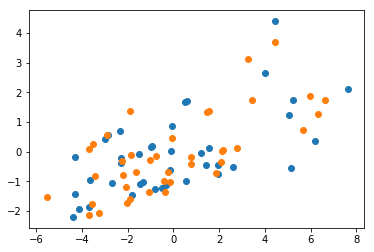

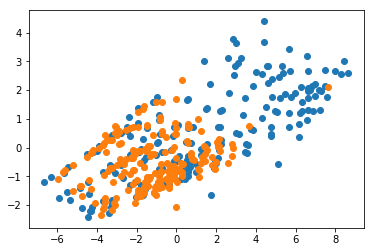

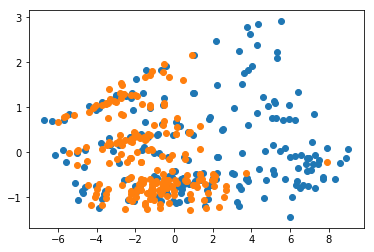

In [9]:
plt.figure()
indices = [0,9]
for i in indices:
    print(np.sum(z==i))
    plt.scatter(X_transformed[z==i, 0], X_transformed[z==i, 1])
plt.figure()
for i in indices:
    print(np.sum(z==i))
    plt.scatter(X_PCA[z==i, 0], X_PCA[z==i, 1])
plt.figure()
plt.scatter(X_transformed[y==0, 0], X_transformed[y==0, 1])
plt.scatter(X_transformed[y==1, 0], X_transformed[y==1, 1])
plt.figure()
plt.scatter(X_PCA[y==0, 0], X_PCA[y==0, 1])
plt.scatter(X_PCA[y==1, 0], X_PCA[y==1, 1])

In [38]:
def sPLS(X,y,lam):
    n = 1./y.shape[0]
    temp = n*np.dot(X.T,y)
    a = np.maximum(np.absolute(temp)-lam,0)
    a = np.sign(temp)*a
    norm = np.linalg.norm(a)
    if norm>0:
        a = a/np.linalg.norm(a)
    return a.flatten(), np.dot(X,a).flatten()

def PLSComponents(X,yprop,lam,n):
    y = yprop-np.mean(yprop)
    comp = np.zeros((n,X.shape[0]))
    residus = copy.deepcopy(X)
    vectors = np.zeros((n,X.shape[1]))
    for i in range(n):
        vectors[i,:],comp[i,:] = sPLS(residus,y,lam)
        y = y - comp[i,:]
        residus = residus-np.outer(comp[i,:],vectors[i,:])
    return comp,vectors

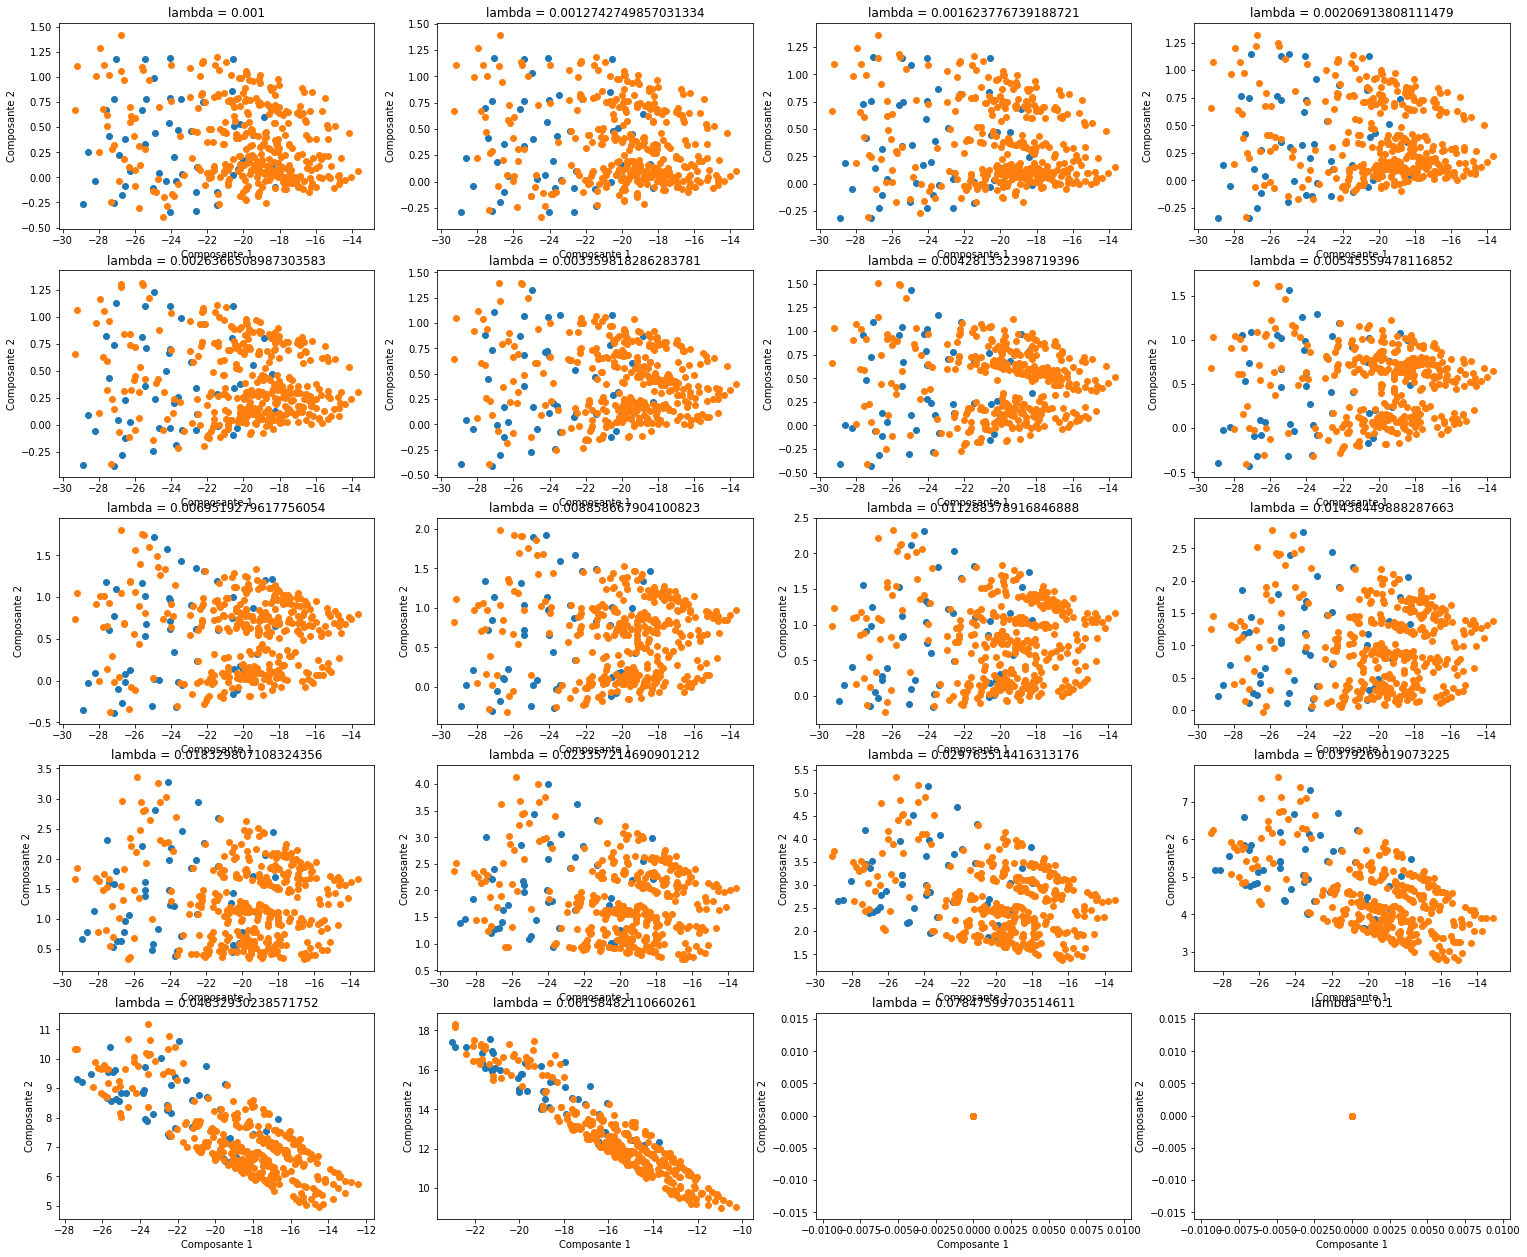

In [39]:
n = 20
lambdatests = np.logspace(-3,-1,20)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(26,22))
for i in range(n):
    lam = lambdatests[i]
    genescompspls,vectorspls = PLSComponents(result,y,lam,2)
    k = i//4
    j = i%4
    axes[k,j].scatter(genescompspls[0,:50],genescompspls[1,:50])
    axes[k,j].scatter(genescompspls[0,50:],genescompspls[1,50:])
    axes[k,j].set_xlabel("Composante 1")
    axes[k,j].set_ylabel("Composante 2")
    axes[k,j].set_title("lambda = "+str(lam))
plt.show()

In [46]:
clf = LDA()
kf = StratifiedKFold(n_splits=5)
lambdas = np.logspace(-3,-1,50)
ncomps = range(2,18)
means = np.zeros((lambdas.shape[0],len(ncomps)))
stds = np.zeros((lambdas.shape[0],len(ncomps)))
k=0
for lam in tqdm(lambdas,'Cross validation'):
    i=0
    for n in ncomps:
        scores = []
        for train_index, test_index in kf.split(result,y):
            traincomps,vectorcomps = PLSComponents(result[train_index,:],y[train_index],lam,n)
            testcomps = np.dot(result[test_index,:],vectorcomps.T)
            clf.fit(traincomps.T,y[train_index].ravel())
            scores.append(clf.score(testcomps,result[test_index].ravel()))
        scores = np.array(scores)
        mean = np.mean(scores)
        std = np.std(scores)
        means[k,i] = mean
        stds[k,i] = std
        i+=1
    k+=1

Cross validation:   0%|                                                                         | 0/50 [00:00<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [9680, 80]

In [61]:
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score

clf = linear_model.Lasso(alpha=0.00001)
clf = svm.SVC(kernel='rbf', C=100, gamma=0.00001)
scores = cross_val_score(clf, result, y, cv=5, shuffle=True)
#clf.fit([[0,0], [1, 1], [2, 2]], [0, 1, 2])

TypeError: cross_val_score() got an unexpected keyword argument 'shuffle'

In [53]:
print(scores)

[0.8625 0.7125 0.7    0.5375 0.575 ]


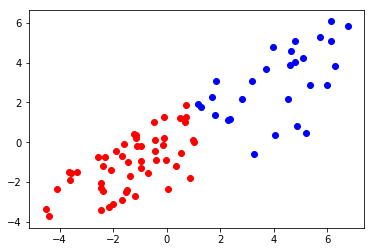

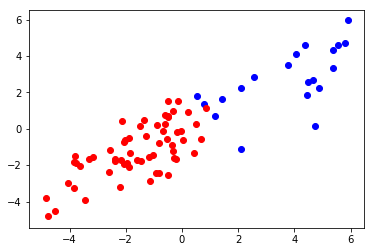

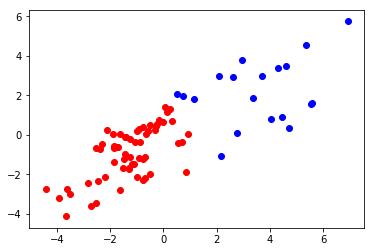

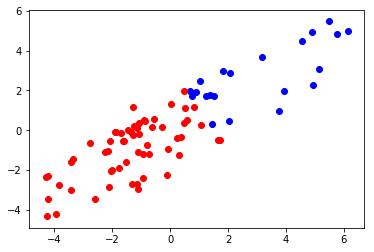

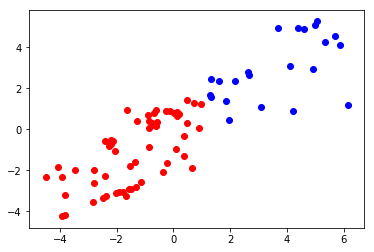

In [57]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)
for train, test in kf.split(result):
    clf.fit(result[train], y[train])
    end = clf.predict(result[test])
    plt.figure()
    plt.scatter(X_transformed[test][end==0, 0], X_transformed[test][end==0, 1], c='b')
    plt.scatter(X_transformed[test][end==1, 0], X_transformed[test][end==1, 1], c='r')